In [1]:
%matplotlib inline
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm import tqdm_notebook as tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
# load pretrained model
from torchvision import models
# for plotting
import random
import matplotlib.patches as patches
from matplotlib.ticker import NullLocator

## download built-in svhn data

In [3]:
# download if necessary
if not os.path.isfile('./data/train_32x32.mat'):
    # use as digital training set
    svhn_train_set = datasets.SVHN('./data',split='train',download=True, transform=transforms.ToTensor())
if not os.path.isfile('./data/test_32x32.mat'):
    # use as digital testing set
    svhn_test_set = datasets.SVHN('./data',split='test',download=True, transform=transforms.ToTensor())
if not os.path.isdir('./data/cifar-10-batches-py'):
    # use as non-digital training set
    cifar10_train_set = datasets.CIFAR10('./data',train=True,download=True,transform=transforms.ToTensor())
    # use as non-digital testing set
    cifar10_test_set = datasets.CIFAR10('./data',train=False,download=True,transform=transforms.ToTensor())
# # print dataset information
# print("svhn train:%d, svhn test:%d, cifar train:%d, cifar test:%d"%(len(svhn_train_set),
#                                                                     len(svhn_test_set),
#                                                                     len(cifar10_train_set),
#                                                                     len(cifar10_test_set)))

###############################
# dataset class
###############################
# combine train and test together
class PartySet(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='./data'):
        'Initialization'
        self.transform = transform
        # load svhn
        self.svhn = datasets.SVHN(data_path,
                                  split='train' if train else 'test', 
                                  transform=transforms.ToTensor())

#         self.cifar = datasets.CIFAR10(data_path,
#                                       train = train,
#                                       transform=transforms.ToTensor())

        data_path = os.path.join(data_path, 'not_digit', 'train' if train else 'test')
        self.image_paths = glob.glob(data_path + '/*.png')
        
        # compute length
        self.l = len(self.svhn) + len(self.image_paths) #len(self.cifar)
        
    def __len__(self):
        'Returns the total number of samples'
        return self.l

    def __getitem__(self, idx):
        'Generates one sample of data'
        if idx >= len(self.svhn):
            # load cifar part
            nidx = idx - len(self.svhn)
#             X = self.cifar.data[nidx]
#             y = 10 # new class, not digital
#             #self.cifar.targets[nidx]
#             X = Image.fromarray(X)
            
            # use self-cropped imgs
            image_path = self.image_paths[nidx]
            image = Image.open(image_path)
            y = 10 # new class not digital
            X = image
        else:
            # load svhn part
            X = self.svhn.data[idx]
            y = self.svhn.labels[idx]
            y = (y) if y < 10 else 0
            X = Image.fromarray(np.transpose(X, (1, 2, 0)))
        if self.transform is not None:
            X = self.transform(X)
            
        return X, y

In [6]:
trainset = PartySet(train=True, transform=transforms.ToTensor())

In [11]:
###############################
# mean, std: too slow, do once
###############################
# imgs_tensor = torch.stack([data[0] for idx, data in tqdm(enumerate(trainset),total=len(trainset))],dim=3)
# imgs_tensor = imgs_tensor.view(3,-1)
# mean = imgs_tensor.mean(dim=1)
# std = imgs_tensor.std(dim=1)
# print('mean:%s, std:%s'%(mean,std))
#### for cifar
# mean = [0.4597, 0.4595, 0.4623]
# std = [0.2208, 0.2200, 0.2258]

#### for cropped 
mean=[0.4378, 0.4394, 0.4583]
std =[0.2005, 0.2039, 0.2029]

# consider data augmentation if necessary
new_transform = transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean,std)])

trainset.transform = new_transform

testset = PartySet(train=False, transform=new_transform)
print(len(testset))

## data loader
batch_size = 128
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

39406


## Visulization some data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


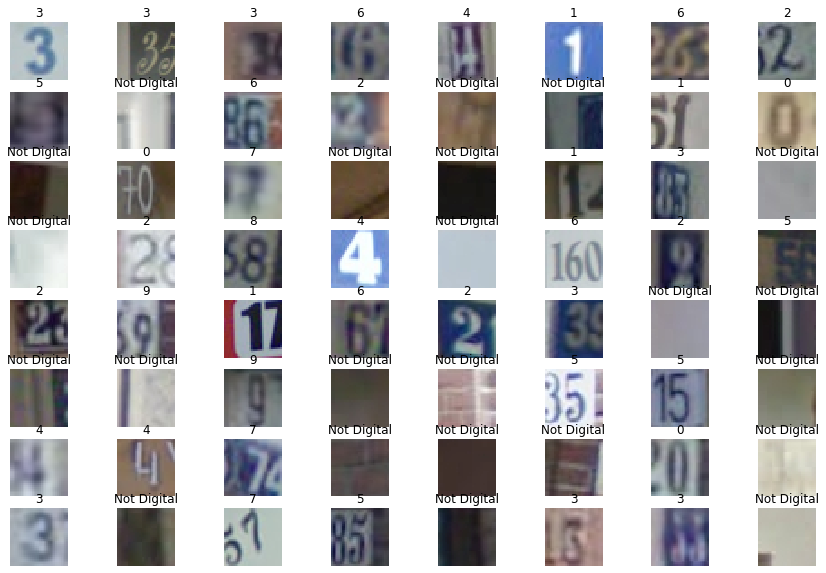

In [12]:
images, labels = next(iter(train_loader))
print(labels.shape)
plt.figure(figsize=(15,10))

label_name = ['0','1','2','3','4','5','6','7','8','9','Not Digital']

for i in range(64):
    plt.subplot(8,8,i+1)
    img = np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1)
    img = img*std+mean
    plt.imshow(img)
    plt.title(label_name[labels[i].item()])
    plt.axis('off')


## Task-1: train a CNN for digits classification
TODO:
1. use a self-defined simple network
2. use pretrained lightweight network

In [39]:
class Network(nn.Module):
    '''
    the first net is inspired by VGG-16.
    '''
    def __init__(self):
        super(Network, self).__init__()
        #...
        self.features = nn.Sequential(
            ## input is 3x32x32
            # layer-1, 32x3x28x28
            nn.Conv2d(3,64,3,stride=1,padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            # layer-2, 16x32x28x28
            nn.Conv2d(64,128,3,stride=1,padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            # pooling, 16x14x14
            nn.MaxPool2d(2,stride=2),
            # layer-3, 32x16x10x10
            nn.Conv2d(128,256,3,stride=1,padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            # layer-4, 16x32x10x10
            nn.Conv2d(256,16,3,stride=1,padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            # pooling, 16x5x5
            nn.MaxPool2d(2,stride=2),
            # 1024x1x1
            nn.Conv2d(16,1024,5,stride=1,padding=0),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Conv2d(1024,1024,1,stride=1,padding=0),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            # 11x1x1
            nn.Conv2d(1024,11,1,stride=1,padding=0)
        )

    def forward(self, x):
        # ...
        out = self.features(x)
        #out = F.softmax(out,dim=0)
        out = out.view(out.size(0), -1)
        return out

## define model and move to deive

In [40]:
usePretrained = False
if usePretrained == False:
    model = Network()
else:
    pass

for param in model.parameters():
    if param.requires_grad == True:
        print(param.shape)

# check if GPU exsit
if torch.cuda.is_available():
    print("The code will run on GPU. This is important so things run faster.")
else:
    print("The code will run on CPU. You should probably not do this.")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)

torch.Size([64, 3, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([256, 128, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([16, 256, 3, 3])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([1024, 16, 5, 5])
torch.Size([1024])
torch.Size([1024, 1024, 1, 1])
torch.Size([1024])
torch.Size([11, 1024, 1, 1])
torch.Size([11])
The code will run on GPU. This is important so things run faster.


Network(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(256, 16, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(16, 1024, kernel_size=(5, 5), stride=(1, 1))
    (15): ReLU()
    (16): Dropout(p=0.5)
    (17): Conv2d(1024, 1024,

## initilize optimizer

In [41]:
#Initialize the optimizer with model parameters that need to be retrained
# optimizer = torch.optim.SGD(filter(lambda param: param.requires_grad, model.parameters()),
#                             lr=1e-2,momentum=0.9)# fine tuning
optimizer = torch.optim.Adam(filter(lambda param: param.requires_grad, model.parameters()),lr=1e-3)






## define training process

In [42]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, num_epochs=10):
    train_acc_all = []
    test_acc_all = []

    cost = torch.nn.CrossEntropyLoss()
    
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        #For each epoch
        train_correct = 0
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            #loss = F.nll_loss(torch.log(output), target)## what does nll_loss mean
            #Use cross-entropy as cost function, it will do softmax internally
            loss = cost(output, target)
            
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()
        
        #Comput the test accuracy
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data = data.to(device)
            with torch.no_grad():
                output = model(data)
            predicted = output.argmax(1).cpu()
            test_correct += (target==predicted).sum().item()
        train_acc = train_correct/len(trainset)
        test_acc = test_correct/len(testset)
        train_acc_all.append(train_acc)
        test_acc_all.append(test_acc)
        print("Accuracy train: {train:.1f}%\t test: {test:.1f}%".format(test=100*test_acc, train=100*train_acc))
    return test_acc_all, train_acc_all

## start training

Accuracy train: 83.9%	 test: 90.6%


Accuracy train: 91.6%	 test: 92.6%


Accuracy train: 93.0%	 test: 94.2%


Accuracy train: 93.9%	 test: 94.7%


Accuracy train: 94.5%	 test: 94.3%


Accuracy train: 95.0%	 test: 94.5%


Accuracy train: 95.5%	 test: 95.0%


Accuracy train: 95.9%	 test: 95.2%


Accuracy train: 96.2%	 test: 95.4%


Accuracy train: 96.5%	 test: 95.2%


Accuracy train: 96.7%	 test: 95.0%


Accuracy train: 96.9%	 test: 95.3%


Accuracy train: 97.2%	 test: 95.2%


Accuracy train: 97.3%	 test: 94.9%


Accuracy train: 97.5%	 test: 94.9%


Accuracy train: 97.6%	 test: 95.2%


Accuracy train: 97.8%	 test: 95.0%


Accuracy train: 97.8%	 test: 95.3%


Accuracy train: 98.0%	 test: 95.0%


Accuracy train: 98.1%	 test: 95.1%


[Text(0, 0.5, 'Accuracy')]

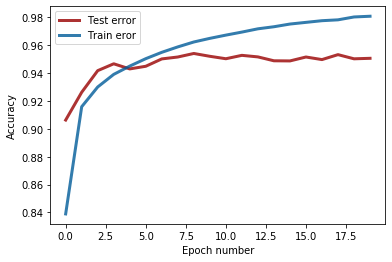

In [43]:
#optimizer = torch.optim.SGD(filter(lambda param: param.requires_grad, model.parameters()), lr=1e-2,momentum=0.9)# fine tuning

test_acc, train_acc = train(model, optimizer, 20)# training

fig,ax = plt.subplots()
ax.plot(test_acc,c='#990000',alpha=0.8,linewidth=3,label='test_acc')
ax.plot(train_acc,c='#005b99',alpha=0.8,linewidth=3,label='train_acc')
# ...
ax.legend(('Test error','Train eror'))
ax.set(xlabel='Epoch number')
ax.set(ylabel='Accuracy')


## end training, save model parameters for later usage

In [44]:

# save trained model for faster analysis
checkpoint_name = './model/party-checkpoint-3.pt'
torch.save(model.state_dict(), checkpoint_name)


## load trained  parameters and start for localization

In [45]:
checkpoint_name = './model/party-checkpoint-3.pt'

# then training
model.load_state_dict(torch.load(checkpoint_name))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [46]:
print(model)

Network(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(256, 16, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(16, 1024, kernel_size=(5, 5), stride=(1, 1))
    (15): ReLU()
    (16): Dropout(p=0.5)
    (17): Conv2d(1024, 1024,

In [47]:
# load failure images
model.eval()
init = False
test_correct = 0
for data, target in test_loader:
    datagpu = data.to(device)
    #print(data.shape)
    with torch.no_grad():
        output = model(datagpu)
        predicted = output.argmax(1).cpu()
        mask = target!=predicted
        failures = data[mask]
        failure_predict_lbs = predicted[mask]
        failure_true_lbs = target[mask]
        test_correct += (target==predicted).sum().cpu().item()
        if init == False:
            init = True
            allfailures = failures
            all_failure_predict_lbs = failure_predict_lbs
            all_failure_true_lbs = failure_true_lbs
        else:
            allfailures = torch.cat((allfailures,failures),dim=0)
            all_failure_predict_lbs = torch.cat((all_failure_predict_lbs,failure_predict_lbs),0)
            all_failure_true_lbs = torch.cat((all_failure_true_lbs,failure_true_lbs),0)
print(len(testset))
print(allfailures.shape)
print(all_failure_predict_lbs)
print(all_failure_true_lbs)
test_acc = test_correct/len(testset)
print('Test Accuracy:%s'%test_acc)

39406
torch.Size([1945, 3, 32, 32])
tensor([9, 9, 5,  ..., 1, 7, 2])
tensor([ 3,  8,  8,  ..., 10, 10, 10])
Test Accuracy:0.9506420342079887


## Use your network with a **convolutional implementation of the sliding window** algorithm to detect bounding boxes around digits.

In [48]:
class PartyFull(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='/scratch/SVHN'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        #print(data_path)
        self.image_paths = glob.glob(data_path + '/*.png')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        # fetch folder name as the class type
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = 0 if c == 'test' else 1
        #print(c)
        X = self.transform(image)
        return X, y

In [49]:
def detection(res_conv, nd_label = 10, score_threshold = 0.6, stride=(4,4), sliding_win_size = (32,32)):
    '''
    input is the convolutional result.
    output is the corresponding bbox.
    '''
    # get predicted label
    score,target = res_conv.max(1)
    score = score.detach()
    # find digital
    mask_digital = (target != nd_label) & (score >= score_threshold)
    #print("target: %s, score: %s"%(target[mask_digital],score[mask_digital]))
     
    # initial detection
    init_detections = torch.nonzero(mask_digital)
    init_detections = init_detections.numpy()
    
    # get coordinates
    coords = init_detections[:,[1,2]]
    rows = coords[:,[0]].flatten()
    cols = coords[:,[1]].flatten()
    #print("rows:%s,cols:%s"%(rows,cols))
    
    # compute bb position
    bbx = stride[0] * cols
    bby = stride[1] * rows
    bbw = np.full_like(bbx,sliding_win_size[0])
    bbh = np.full_like(bby,sliding_win_size[1])
    label = target[mask_digital].numpy()
    score = score[mask_digital].numpy()
    bb = np.vstack((bbx,bby,bbw,bbh,label,score)).transpose()
    #print(bb[:,0])
    
    return bb

In [50]:

cmap = plt.get_cmap("tab20")
colors = [cmap(i) for i in np.linspace(0, 1, 11)]
classes_name = ['0','1','2','3','4','5','6','7','8','9','Not Digital']
n_cls_preds = len(classes_name)
bbox_colors = random.sample(colors, n_cls_preds)

def rescale_boxes(boxes, current_dim, original_shape):
    """ Rescales bounding boxes to the original shape """
    orig_h, orig_w = original_shape
    # The amount of padding that was added
    pad_x = max(orig_h - orig_w, 0) * (current_dim / max(original_shape))
    pad_y = max(orig_w - orig_h, 0) * (current_dim / max(original_shape))
    # Image height and width after padding is removed
    unpad_h = current_dim - pad_y
    unpad_w = current_dim - pad_x
    # Rescale bounding boxes to dimension of original image
    boxes[:, 0] = ((boxes[:, 0] - pad_x // 2) / unpad_w) * orig_w
    boxes[:, 1] = ((boxes[:, 1] - pad_y // 2) / unpad_h) * orig_h
    boxes[:, 2] = ((boxes[:, 2] - pad_x // 2) / unpad_w) * orig_w
    boxes[:, 3] = ((boxes[:, 3] - pad_y // 2) / unpad_h) * orig_h
    return boxes


def plotbbox(detections,img_size,original_img_size,ax):
    # Draw bounding boxes and labels of detections
    if detections is not None:
        # Rescale boxes to original image
        #detections = rescale_boxes(detections, img_size, original_img_size)
        # random sampling from color map
        
        for bbx, bby, bbw, bbh, cls_pred, cls_conf in detections:
            print("\t+ Label: %s, Conf: %.5f" % (classes_name[int(cls_pred)], cls_conf))
            color = bbox_colors[int(cls_pred)]
            # Create a Rectangle patch
            bbox = patches.Rectangle((bbx, bby), bbw, bbh, linewidth=2, edgecolor=color, facecolor="none")
            # Add the bbox to the plot
            ax.add_patch(bbox)
            # Add label
            plt.text(
                bbx,
                bby,
                s=classes_name[int(cls_pred)],
                color="white",
                verticalalignment="top",
                bbox={"color": color, "pad": 0},
            )
    return

In [51]:
def IoU(detection1, detection2):
    area1 = detection1[2]*detection1[3]
    area2 = detection2[2]*detection2[3]
    # intersection
    sx = np.max([detection1[0],detection2[0]])
    sy = np.max([detection1[1],detection2[1]])
    ex = np.min([detection1[0]+detection1[2],detection2[0]+detection2[2]])
    ey = np.min([detection1[1]+detection1[3],detection2[1]+detection2[3]])
#     print(detection1)
#     print(detection2)
#     print('sx:%s,sy:%s,ex:%s,ey:%s'%(sx,sy,ex,ey))
    area_intersected = (ex-sx)*(ey-sy)
    # union
    area_union = area1 + area2 - area_intersected
    return (area_intersected/area_union)

# test1 = [10,10,100,100]
# test2 = [102,102,50,100]
# print(IoU(test2,test1))

In [52]:
def nms_bbox(detections, classes, threshold = 0.5):
    '''
    Apply Non-Maximum Suppression
    '''
    maximum = []
    indices = np.arange(detections.shape[0],dtype=int)
    for i in range(len(classes)):
        label = classes[i]
        mask = detections[:,4] == label
        indices_of_label = indices[mask]
#         print(indices_of_label.shape)
        while len(indices_of_label) > 0:
            # find the one with lagest score
            maxid = np.argmax(detections[indices_of_label,5])
            # output
            id1 = indices_of_label[maxid]
            maximum.append(id1)
            # 
            remove_id = np.ones(len(indices_of_label),dtype=int)
            for j in range(len(indices_of_label)):
                iou = IoU(detections[indices_of_label[j],:], detections[id1,:])
#                 print('i:%s, iou:%s'%(i,iou))
                if iou < threshold:
                    # keep
                    remove_id[j] = 0
            indices_of_label = indices_of_label[remove_id == 0]
        
#     visited = np.zeros(detections.shape[0])
#     for i in range(detections.shape[0]):
#         if visited[i] != 0:
#             continue
#         # not yet visited
#         visited[i] = 1
#         label = detections[i,4]
#         indices = np.arange(detections.shape[0])
#         available_id = np.ones(detections.shape[0],dtype=int)
#         available_id[i] = 0
#         #available_id[detections[:,4] != label] = 0
#         available_id[visited != 0] = 0
#         mask = available_id != 0
#         # get similar detections that have not been visited
#         similar_detections = detections[mask,:]
#         if similar_detections.shape[0] == 0:
#             maximum.append(i)
#             continue
        
#         indices = indices[mask]
#         mask2 = (similar_detections[:,0] >= detections[i,0]) & \
#                 (similar_detections[:,1] >= detections[i,1]) & \
#                 (similar_detections[:,0] < (detections[i,0]+detections[i,2])) & \
#                 (similar_detections[:,1] < (detections[i,1]+detections[i,3]))
#         similar_detections = similar_detections[mask2,:]
#         if similar_detections.shape[0] == 0:
#             maximum.append(i)
#             continue
        
#         indices = indices[mask2]
#         # now, we have detections with the same label and intersected
#         #print(similar_detections[:,5])
#         maxid = np.argmax(similar_detections[:,5])
#         #print(maxid)
#         if detections[i,5] >= similar_detections[maxid,5]:
#             # if current box is the box with the largest score,
#             # remove overlapping boxes which has an IoU over 0.5
#             maximum.append(i)
#             mask3 = np.ones(len(indices),dtype=int)
#             for k in range(len(indices)):
#                 if IoU(detections[i,:], similar_detections[k,:]) >= threshold:
#                     # remove
#                     continue
#                 else:
#                     mask3[k] = 0
#             remove_indices = indices[mask3 == 1]
#             visited[remove_indices] = 1
#         else:
#             # if current box is not the box with the largest score
#             continue
    detections = detections[maximum,:]
        
    return detections
            

13068
	+ Label: 1, Conf: 0.99034
	+ Label: 1, Conf: 0.92407
	+ Label: 2, Conf: 1.00000
	+ Label: 3, Conf: 0.98318
	+ Label: 4, Conf: 0.92885
	+ Label: 5, Conf: 1.00000
	+ Label: 8, Conf: 0.92343


<Figure size 1440x720 with 0 Axes>

<Figure size 432x288 with 0 Axes>

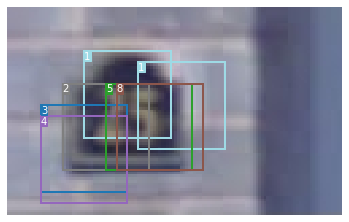

In [55]:
full_test_set = PartyFull(train=False, transform=new_transform)
print(len(full_test_set))
full_test_loader = DataLoader(full_test_set, 
                              batch_size=1, shuffle=True, num_workers=1)

model.eval()
model.to(device)
plt.figure(figsize=(20,10))
classes = np.arange(10)
for data, label in full_test_loader:
    datagpu=data.to(device)
    img = data[0].numpy().transpose((1,2,0))
    img = img*std+mean
    # Create plot
    plt.figure()
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    
    # load image, apply cnn, it equivalents to run sliding window with stride = 4 
    # because of using two max-pooling: batch_size x channels x H x W
    res_conv = model.features(datagpu)
    res_conv = F.softmax(res_conv,dim=1).cpu()
    #print(F.softmax(res_conv,dim=1))
    #print((F.softmax(res_conv,dim=1)).argmax(1))
    #print("input:%s, output:%s"%(data.shape,res_conv.shape))
    
    # detection results
    detections = detection(res_conv, 10, 0.9, stride=(4,4), sliding_win_size=(32,32))
    #print(detections)
    detections = nms_bbox(detections,classes,0.3)
    
    plotbbox(detections,img.shape[:1],img.shape[:2],ax)
    
    # Save generated image with detections
    plt.axis("off")
    plt.gca().xaxis.set_major_locator(NullLocator())
    plt.gca().yaxis.set_major_locator(NullLocator())

    break

In [229]:
detections = nms_bbox(detections,classes,0.5)

(0,)
(5,)
[ 0.  0. 32. 32.  1.  1.]
[ 0.  0. 32. 32.  1.  1.]
sx:0.0,sy:0.0,ex:32.0,ey:32.0
i:1, iou:1.0
[24.          0.         32.         32.          1.          0.99999964]
[ 0.  0. 32. 32.  1.  1.]
sx:24.0,sy:0.0,ex:32.0,ey:32.0
i:1, iou:0.14285714285714285
[68.         4.        32.        32.         1.         0.9998073]
[ 0.  0. 32. 32.  1.  1.]
sx:68.0,sy:4.0,ex:32.0,ey:32.0
i:1, iou:-0.3298429319371728
[12.          4.         32.         32.          1.          0.98793948]
[ 0.  0. 32. 32.  1.  1.]
sx:12.0,sy:4.0,ex:32.0,ey:32.0
i:1, iou:0.3763440860215054
[56.          0.         32.         32.          1.          0.91285878]
[ 0.  0. 32. 32.  1.  1.]
sx:56.0,sy:0.0,ex:32.0,ey:32.0
i:1, iou:-0.2727272727272727
[24.          0.         32.         32.          1.          0.99999964]
[24.          0.         32.         32.          1.          0.99999964]
sx:24.0,sy:0.0,ex:56.0,ey:32.0
i:1, iou:1.0
[68.         4.        32.        32.         1.         0.9998073]
[2

In [204]:
a = torch.Tensor([[1,22,3],[2,33,44]])
print(a)
print(a[1][2])
print(F.softmax(a,dim=0))
print(a.shape)
w,h=a.shape

tensor([[ 1., 22.,  3.],
        [ 2., 33., 44.]])
tensor(44.)
tensor([[2.6894e-01, 1.6701e-05, 1.5629e-18],
        [7.3106e-01, 9.9998e-01, 1.0000e+00]])
torch.Size([2, 3])


In [42]:
torch.manual_seed(4)
x = torch.rand(3,4)
y = torch.rand(3,4)
print('x', x)
val, argmax = x.max(1)
print('max',val)
print('argmax', argmax)
y[np.arange(3), argmax] = 3
print('y', y)

x tensor([[0.5596, 0.5591, 0.0915, 0.2100],
        [0.0072, 0.0390, 0.9929, 0.9131],
        [0.6186, 0.9744, 0.3189, 0.2148]])
max tensor([0.5596, 0.9929, 0.9744])
argmax tensor([0, 2, 1])
y tensor([[3.0000, 0.4735, 0.5949, 0.7956],
        [0.7635, 0.2137, 3.0000, 0.0386],
        [0.5220, 3.0000, 0.6074, 0.5233]])


In [41]:
a = np.array([[1,2,3]])
a = a.flatten()
print(a)
b = (4,5)
print(b[1])
img = np.ones((320,240),dtype=int)
a = np.array([np.arange(10),np.arange(10,20)]).transpose()
print(a)
for i,j in a:
    print((i,j))
a[[[1,2],[4,5]],:]

[1 2 3]
5
[[ 0 10]
 [ 1 11]
 [ 2 12]
 [ 3 13]
 [ 4 14]
 [ 5 15]
 [ 6 16]
 [ 7 17]
 [ 8 18]
 [ 9 19]]
(0, 10)
(1, 11)
(2, 12)
(3, 13)
(4, 14)
(5, 15)
(6, 16)
(7, 17)
(8, 18)
(9, 19)


array([[[ 1, 11],
        [ 2, 12]],

       [[ 4, 14],
        [ 5, 15]]])

In [101]:
a = np.arange(10)
print(len(a))
cc = [1,2,3,4,5,6]
cc.pop([2,3,4])
print(cc)


10


TypeError: 'list' object cannot be interpreted as an integer